# <center> Training Greedy Chocolate Agent </center>

<center> We are going to train tabular reinforcement learning agents for the greedy chocolate game. <center>

<br><br>
  
<img src="img/img_chocolates.jpeg" alt="Chocolates pic." width="160" height="200">
    
<br><br>
Game rules:

Given some boxes of chocolates. Each turn a player must pick a box and take at least one chocolate in that boxes. Player can't take chocolate more than the amount of chocolate in a chosen box. Whenever pick the last chocolate is greedy (losing the game).

# Table of Content
1. [Load Packages and Data](#step1)
2. [Initialize game and Trainer](#step2)
3. [Initialize Agent](#step3)
4. [Training QLearning Agent](#step4)
 - [Train Q Agent vs Random Agent](#step4a)
 - [Training Result](#step4b)
 - [Play Strategy](#step4c)
5. [Training Other Agent](#step5)
 - [Train Expected Sarsa Agent vs Random Agent](#step5a)
 - [Training Result](#step5b)
6. [Self Play](#step6)
 - [Train Self Play Agent](#step6a)
 - [Training Result](#step6b)
7. [Learn Agent's Strategy](#step7)
 - [Value Function](#step7a)
 - [Losing State Analysis](#step7b)

## 1. Load Packages<a name=step1></a>

In [1]:
# Import libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Game environment
from environment import Environment

# Tabular RL Agent
from agent.base_agent import RandomAgent
from agent.td_agent import QLearningAgent
from agent.td_agent import ExpectedSarsaAgent

# Training method for two player game
from trainer import TwoPlayerGameTrainer

## 2. Initialize game and Trainer<a name=step2></a>

First of all, we need to set the environment and the trainer. The environment.py script contains the simulated environment that is similar to OpenAI environment. The **TwoPlayerGameTrainer** contains several methods for training two player game. 

We'll be using 3 boxes of chocolates with a random number of chocolates between 3 to 20.

In [2]:
# Game parameter, 3 section is recommended
BOXES = 3
MAX_CHOCOLATE = 20
MIN_CHOCOLATE = 3

# Setting up the game environment and trainer
env = Environment(SECTION=BOXES, MAX_CHOCOLATE=MAX_CHOCOLATE, MIN_CHOCOLATE=MIN_CHOCOLATE)
trainer = TwoPlayerGameTrainer()

In [3]:
env.game.print_init()




Welcome to greedy test game!


People avoid taking the last chocolate because
it's a sign of greediness.

You can take any chocolates in a box
(as long as it's sufficient).

Just don't be the person to take the last chocolate!



## 3. Initialize Agent<a name=step3></a>

To train an agent in a zero sum game setting, we have to fix one agent (no training), so that our environment doesn't change. We also initialize QLearning agent with learning rate $(\alpha)$ of 0.05 and $\epsilon$=0.3. In this game, we set discount rate ($\gamma$) = 1.

In [4]:
# Fixed random agent
agent_random = RandomAgent()

# QLearning Agent
agent_q = QLearningAgent(alpha=0.05, epsilon=0.4, discount=1)

## 4. Train QLearning Agent<a name=step4></a>

### Training Q Agent vs Random Agent<a name=step4a></a>

The function to train the agent has been implemented on trainer.py script. 

We want to use *play_and_train* in **TwoPlayerGameTrainer** class. It has the following arguments:

 * env -> game environment
 * agent1 -> agent that will learn
 * agent2 -> fixed agent that will be considered as environment
 * n_games -> number of games to play/train
 * learn -> indicates whether agent1 is training or just evaluating
 * verbose -> to print the output
 
The method will set the learning mode of agent2 off and play n_games games with agent1 while training agent1.

QLearning uses the following update rule for the q value:

> $$Q(S, A) = Q(S, A) + \alpha[R + \gamma max_{a}Q(S', a) - Q(S, A)]$$

In [5]:
history, win_rate = trainer.play_and_train(env, agent_q, agent_random, n_games = 20000, learn=True)

Running game: 20000
Done!


### Q Agent Training Result<a name=step4b></a>

It is interesting to see how the training went. The variable history contains an array with length 20000. Each element represents the game result, +1 if agent_q wins, -1 otherwise. We can calculate the cumulative sum and make a plot to understand the training process

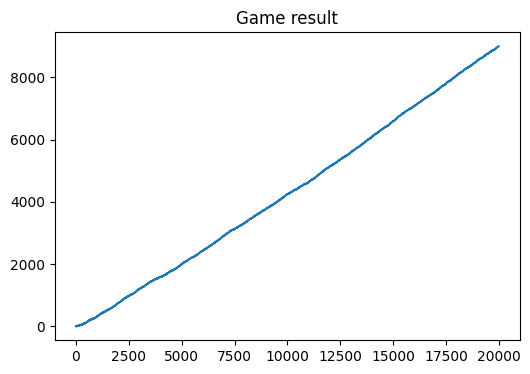

In [6]:
history_cumsum = np.cumsum(history)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
_ = ax.plot(history_cumsum)
_ = ax.set_title("Game result")
plt.show()

It seems our agent learns well even though it still on the learning mode. Let's set the learning mode off and calculate the winning rate.

**Note:** Setting the learning mode off will behaves greedily, since it removes exploration factor

In [7]:
_, win_rate = trainer.play_and_train(env, agent_q, agent_random, n_games = 2000, learn=False)

print(f"\n\nWin rate: {win_rate}")

Running game: 2000
Done!


Win rate: 0.904


Awesome, now we can save the model. We use **defaultdict** as our data structure to save q table. Each agent is equipped with *save_model* and *load_model* methods. We'll use .npy format. 

Naming convention: "agentName_vs_opponentName_section_MinChocolate_MaxChocolate.npy"

In [8]:
agent_q.save_model(os.path.join("model", "qagent_vs_random_3_3_20.npy"))

### View Play Strategy<a name=step4c></a>

To view the actual play, we can use play method in TwoPlayerGameTrainer class

In [9]:
_ = trainer.play(env, agent_q, agent_random, reset=True, verbose=True)


----------------------------------------------------------------


Chocolate box:

Box 1: 4
Box 2: 11
Box 3: 4

Player 1: take 10 chocolates from box 2...

----------------------------------------------------------------


Chocolate box:

Box 1: 4
Box 2: 1
Box 3: 4

Player 2: take 1 chocolates from box 1...

----------------------------------------------------------------


Chocolate box:

Box 1: 3
Box 2: 1
Box 3: 4

Player 1: take 2 chocolates from box 3...

----------------------------------------------------------------


Chocolate box:

Box 1: 3
Box 2: 1
Box 3: 2

Player 2: take 1 chocolates from box 2...

----------------------------------------------------------------


Chocolate box:

Box 1: 3
Box 2: 0
Box 3: 2

Player 1: take 1 chocolates from box 1...

----------------------------------------------------------------


Chocolate box:

Box 1: 2
Box 2: 0
Box 3: 2

Player 2: take 2 chocolates from box 1...

----------------------------------------------------------------


Chocol

## 5. Train Other Agent<a name=step5></a>

### Train Expected Sarsa Agent<a name=step5a></a>

At this moment, we can freely pick any agent with its opponents for training purposes. Let's say we want to train ExpectedSarsa Agent vs our previous trained Q Agent. Setting the agent2 argument as *agent_q* will set its learning mode off. Therefore it omits the exploration behaviour.

In [10]:
agent_ESarsa = ExpectedSarsaAgent(alpha=0.05, epsilon=0.2, discount=1)

In [11]:
history, _ = trainer.play_and_train(env, agent_ESarsa, agent_q, n_games = 20000, learn=True)

Running game: 20000
Done!


### View Training Result<a name=step5b></a>

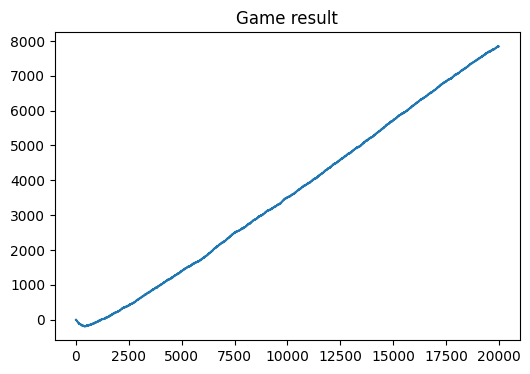

In [12]:
history_cumsum = np.cumsum(history)
fig, ax = plt.subplots(1, 1, figsize=(6,4))
_ = ax.plot(history_cumsum)
_ = ax.set_title("Game result")
plt.show()

At first, the ESarsa Agent keeps losing because Q Agent behaves optimally. As the training goes, the ESarsa Agent improves and keep winning.

In [13]:
_, win_rate = trainer.play_and_train(env, agent_ESarsa, agent_q, n_games = 20000, learn=False, verbose=False)
print(f"Win rate for ESarsa Agent: {win_rate}")


Done!
Win rate for ESarsa Agent: 1.0


The question of interest is: "If we keep doing this over and over again, does the agent becomes better?"

## 6. Self Play<a name=step6></a>

### Train Self Play Agent<a name=step6a></a>

Many reinforcement learning on a competitive game implement self play algorithm. Self play trains the agent to play against itself and keep improving its behaviour.

The *selfplay* method is implemented on **TwoPlayerGameTrainer** class.


Algorithm: 
 1. Turn on agent's learning mode
 2. Make a copy of the agent as old_agent
 3. Set old_agent learning mode off
 4. Train against itself using play_and_train method by setting agent1=agent and agent2=old_agent
 5. Go back to number 2 until stopping criteria is met
 
Let's initialize QLearningAgent and train using self play!

In [14]:
agent_selfplay = QLearningAgent(alpha=0.05, epsilon=0.4, discount=1)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

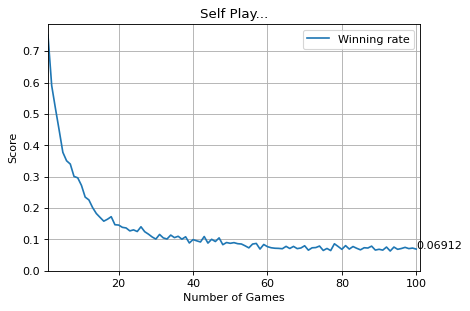

In [15]:
start_time = time.time()
agent_selfplay, _ = TwoPlayerGameTrainer.self_play(
    env, agent_selfplay, n_games=25000, iteration=100, plot_output=True
)
time_delta = time.time() - start_time

In [16]:
print(f"Time elapsed: {time_delta // 60} minutes and {round(time_delta % 60, 3)} seconds")

Time elapsed: 23.0 minutes and 17.283 seconds


Several observations:
 1. The win rate of agent against the previous version of itself is bad
 2. The win rate keeps decreasing
 
During training, the previous version of the agent is set to behaves optimally (learning mode off) whereas the agent needs to balance the exploration and exploitation (learning mode on). Setting the learning mode off is the same as turning off the epsilon when taking an action, so the agent will always take the best action on any given state.

Also, the agent is getting better over time. By playing with itself with learning mode on (taking random action with probability $\epsilon$), the number of wins will decrease over time.

In [17]:
agent_selfplay.save_model(os.path.join("model", "qagent_self_play_3_20_20.npy"))

### View Self-Play Training Result<a name=step6b></a>

**Self play Agent vs Q Agent**

In [18]:
_, win_rate = trainer.play_and_train(
    env, agent_selfplay, agent_q, n_games=10000, learn=False, verbose=False
)


Done!


In [19]:
print(f"Self play Agent vs Q Agent win rate: {win_rate}")

Self play Agent vs Q Agent win rate: 0.9999


#### Self play Agent vs ESarsa Agent

In [20]:
_, win_rate = trainer.play_and_train(
    env, agent_selfplay, agent_ESarsa, n_games=10000, learn=False, verbose=False
)


Done!


In [21]:
print(f"Self play Agent vs ESarsa Agent win rate: {win_rate}")

Self play Agent vs ESarsa Agent win rate: 1.0


#### Self play Agent vs Random Agent

In [22]:
_, win_rate = trainer.play_and_train(
    env, agent_selfplay, agent_random, n_games=10000, learn=False, verbose=False
)


Done!


In [23]:
print(f"Self play Agent vs Random Agent win rate: {win_rate}")

Self play Agent vs Random Agent win rate: 1.0


## 7. Learn Agent's Strategy<a name=step7></a>

Is it possible to learn agent's winning strategy? Yes we can! We can definitely do that by making inferences from agent's q table.

Here are two ways that I found:
 1. Look at the q table and pick the action that has the highest value
 2. Look at the losing state from the value function
 
We will be implementing 2 since it much easier than 1.

### Value Function<a name=step7a></a>

First, we need to get the value function for all states. The value function is the expected cumulative returns on a given state, so it represents the goodness of a state. For Q Agent, it can be calculated using the following equation:

> $$V(s) = max_{a}Q(s, a), \forall s \in \mathcal{S}^{+}$$

Where $\mathcal{S}^{+}$ is the set of all states including the ending/losing state. The equation only works for Q Agent since for each state it behaves greedily by taking the best action.

Here is the value function for self play agent:

In [24]:
states = list(agent_selfplay._qvalues.keys())
values = []
for state in states:
    values.append(round(agent_selfplay.get_value(state), 4))
    
value_of_states = pd.DataFrame({'State': states, 'Value': values})

In [25]:
value_of_states

,State,Value
0,"(7, 6, 5)",1.0
1,"(0, 5, 5)",-1.0
2,"(0, 3, 5)",1.0
3,"(0, 1, 5)",1.0
4,"(0, 0, 4)",1.0
...,...,...
9231,"(20, 1, 18)",0.0
9232,"(20, 1, 19)",0.0
9233,"(18, 2, 20)",0.0
9234,"(20, 2, 19)",0.0


Now, the question is "how do we know the losing states?"

Since we trained the agent using discount rate of 1 (undiscounted), we can easily find the losing states by looking at the state that has the value of -1. 

Also, there are many repetition of the state representation. For example, (0, 0, 1) is the same as (0, 1, 0) and (1, 0, 0) which are the losing states. The way to handle this problem is to sort them and removes duplicates.

In [26]:
# Helper function to sort the state
def unified_state(state):
    # Convert to list
    state=list(state)
    # Sort the state
    state.sort()
    # Convert back to tuple and return
    return tuple(state)

In [27]:
# Sort state
value_of_states["State"] = value_of_states.apply(lambda row: unified_state(row[0]), axis=1)

# Filter for value < -0.8 since some states might not have enough training samples
value_of_states = value_of_states[value_of_states["Value"] < -0.8]

# Drop for duplicates
value_of_states = value_of_states.drop_duplicates(subset=["State"]).reset_index(drop=True)

In [32]:
value_of_states.head(10)

,State,Value
0,"(0, 5, 5)",-1.0000
1,"(0, 0, 1)",-1.0000
2,"(3, 4, 7)",-1.0000
3,"(0, 3, 3)",-1.0000
4,"(5, 9, 12)",-0.9992
5,"(4, 8, 12)",-1.0000
6,"(0, 10, 10)",-1.0000
7,"(1, 4, 5)",-1.0000
8,"(0, 4, 4)",-1.0000
9,"(6, 8, 14)",-0.9950


In [29]:
losing_states = value_of_states["State"]

### Losing States Analysis<a name=step7b></a>

Here are the losing states: 

In [30]:
losing_states.sort_values()

1       (0, 0, 1)
12      (0, 2, 2)
3       (0, 3, 3)
8       (0, 4, 4)
0       (0, 5, 5)
18      (0, 6, 6)
48      (0, 7, 7)
43      (0, 8, 8)
33      (0, 9, 9)
6     (0, 10, 10)
30    (0, 11, 11)
35    (0, 12, 12)
49    (0, 13, 13)
47    (0, 14, 14)
50    (0, 15, 15)
51    (0, 16, 16)
16    (0, 17, 17)
20      (1, 1, 1)
15      (1, 2, 3)
7       (1, 4, 5)
17      (1, 6, 7)
19      (1, 8, 9)
24    (1, 10, 11)
41    (1, 12, 13)
42    (1, 14, 15)
53    (1, 16, 17)
13      (2, 4, 6)
29      (2, 5, 7)
44     (2, 8, 10)
22     (2, 9, 11)
40    (2, 12, 14)
52    (2, 13, 15)
2       (3, 4, 7)
36      (3, 5, 6)
25     (3, 8, 11)
32     (3, 9, 10)
34    (3, 12, 15)
45    (3, 13, 14)
5      (4, 8, 12)
31     (4, 9, 13)
27    (4, 10, 14)
26    (4, 11, 15)
46     (5, 8, 13)
4      (5, 9, 12)
28    (5, 10, 15)
14    (5, 11, 14)
9      (6, 8, 14)
21     (6, 9, 15)
11    (6, 10, 12)
39    (6, 11, 13)
38     (7, 8, 15)
37     (7, 9, 14)
23    (7, 10, 13)
10    (7, 11, 12)
Name: State, dtype: object

#### Trivial States

 * The trivial losing state is $(0, 0, 1)$ since taking we must take the last chocolate.
 * The state $(1, 1, 1)$ is also a losing state because we can only take a chocolate on a chosen box. After taking one chocolate from any boxes, the opponent must take a chocolate in any boxes, and we are left with the state $(0, 0, 1)$.

#### Twin States

Looking at the table, it seems the losing state has a form of $(0, n, n)$ where $n \in \mathbb{N}$. So we conclude that the other losing state is $(0, n, n), \forall n \in \mathbb{N}\setminus \{1\}$ which we call twin state. 

We can easily prove this:

Base case $n = 2$:

The current state is $(0, 2, 2)$. The distinct choice to make is taking 1 chocolate from box 2 or 3, or taking 2 chocolates from box 2 or 3.
 * Player takes 1 chocolate from box 2, the opponent will take 2 chocolates from box 3 and there's only one chocolate left.
 * Player takes 2 chocolates from box 2, the opponent will take 1 chocolate from box 1 and there's only one chocolate left.

Without loss of generality, the opponent can also left us with one chocolate if we take chocolate from box 3.

Suppose that $\forall v \le$ n and $v \ge 2$, the state $(0, v, v)$ is a losing state. Consider the state $(0, n+1, n+1)$. The choices available are taking $c$ chocolates with $c \in \{1, 2, \dots, n+1\}$ in box 2 or 3. We separate them into three cases:
 * Player takes $c$ chocolates from box 2 with $c \in \{1, 2, \dots, n-1\}$. Then the opponent will also take $c$ chocolate. Our current state is $(0, n+1-c, n+1-c)$, from the hypothesis we know that this is a losing state.
 * Player takes $n$ chocolates from box 2. Then the opponent will take $n+1$ chocolates from box 3, leaving us with $(0, 1, 0)$ which is a trivial losing state.
 * Player takes $n+1$ chocolates from box 2. Then the opponent will take $n$ chocolates from box 3, leaving us with $(0, 0, 1)$ which is a trivial losing state.

Without loss of generality, taking chocolate from box 3 will produce the same results.

Therefore, the state $(0, n, n), \forall n \in \mathbb{N} \setminus \{1\}$ is a losing state.

#### Other Losing States

The other losing states doesn't seems to have explicit formula, but one losing state is connected to the other losing state.

For example, $(1, 4, 5)$.
 * If opponent pick 1 chocolate from box 1 or box 3: we can pick one chocolate to give twin state
 * If opponent pick (1, 2) chocolates from box 2 or (2, 3) chocolates from box 3: We can pick chocolate to force the losing state $(1, 2, 3)$
 * Otherwise, we can always make the trivial losing state: $(0, 0, 1)$ or $(1, 1, 1)$

### Strategy Implementation

To implement this strategy, we have to pick chocolates on a box so that the opponent state is any of the losing states